The number of qubits represents the number of input variables
One big layer is represented by 2 sub-layers:
-  First sublayer is represented by RX,RY, and RZ. One gate of each per qubit with its respective weight(theta)
-  Second sublayer is represented by the entanglement between all the qubits

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

In [2]:


def one_qubit_rotation(qc, weights):
    """
    Adds rotation gates around the X, Y, and Z axis to the quantum circuit for a specific qubit,
    with the rotation angles specified by the values in `symbols`.
    """
    # Assume `qc` is your QuantumCircuit object that's defined outside this function
    for qubit in qc.qubits:
        index=qubit.index
        print(index+0, index+3, index+6)
        qc.rx(weights[index+0], index)  # Rotate around X-axis
        qc.ry(weights[index+3], index)  # Rotate around Y-axis
        qc.rz(weights[index+6], index)  # Rotate around Z-axis

def entangling_layer(qc:QuantumCircuit):
    """
    Adds a layer of CZ entangling gates (controlled-Z) on `qubits` (arranged in a circular topology) to the quantum circuit.
    """
    # Assume `qc` is your QuantumCircuit object that's defined outside this function
    for i in range(qc.num_qubits - 1):
        qc.cz(i, i+1)  # Apply CZ between consecutive qubits
    if qc.num_qubits > 2:  # If more than 2 qubits, connect the first and last qubits to form a circle
        qc.cz(0, qc.num_qubits-1)


In [3]:
import sympy


def generate_circuit(qc, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    
    n_qubits=qc.num_qubits
    params = ParameterVector("theta", 3*n_qubits*n_layers+3*n_qubits)
    print(params)
    # Sympy symbols for encoding angles
    inputs= ParameterVector("inputs", n_qubits)
    print(inputs)
    for l in range(n_layers):
        # Variational layer
        print(l*n_qubits*3,(l+1)*n_qubits*3)
        one_qubit_rotation(qc, params[l*n_qubits*3:(l+1)*n_qubits*3])
        entangling_layer(qc)
        # Encoding layer
        qc.barrier()
        for i in range(n_qubits):
            print(n_qubits+i)
            qc.rx(inputs[i], i)
    # # Last varitional layer
    print(n_layers*n_qubits*3,(n_layers+1)*n_qubits*3)
    one_qubit_rotation(qc, params[n_layers*n_qubits*3:(n_layers+1)*n_qubits*3])
    # circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))
    # 
    return qc, list(params), list(inputs)

In [4]:
params = ParameterVector("theta", 3*3*1)

print(params[0:3][0])

theta[0]


0 3 6
1 4 7
2 5 8
0 3 6
1 4 7
2 5 8


/tmp/ipykernel_93175/506020373.py:8: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed in the Qiskit 1.0 release. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  index=qubit.index


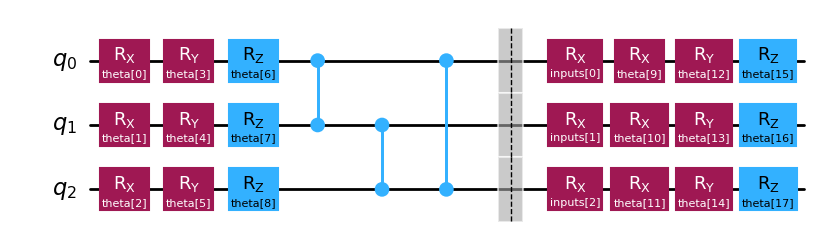

In [5]:
qc = QuantumCircuit(3)
params = ParameterVector("theta", 3*3*1+9)
inputs= ParameterVector("inputs", 3*1)
one_qubit_rotation(qc, params[0:9])
entangling_layer(qc)
qc.barrier()
for i in range(3):
    qc.rx(inputs[i], i)
one_qubit_rotation(qc, params[9:18])


qc.draw("mpl", style="iqx")


In [6]:
print(params)

theta, ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'theta[7]', 'theta[8]', 'theta[9]', 'theta[10]', 'theta[11]', 'theta[12]', 'theta[13]', 'theta[14]', 'theta[15]', 'theta[16]', 'theta[17]']


theta, ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'theta[7]', 'theta[8]', 'theta[9]', 'theta[10]', 'theta[11]', 'theta[12]', 'theta[13]', 'theta[14]', 'theta[15]', 'theta[16]', 'theta[17]', 'theta[18]', 'theta[19]', 'theta[20]', 'theta[21]', 'theta[22]', 'theta[23]', 'theta[24]', 'theta[25]', 'theta[26]', 'theta[27]', 'theta[28]', 'theta[29]', 'theta[30]', 'theta[31]', 'theta[32]', 'theta[33]', 'theta[34]', 'theta[35]', 'theta[36]', 'theta[37]', 'theta[38]', 'theta[39]', 'theta[40]', 'theta[41]', 'theta[42]', 'theta[43]', 'theta[44]', 'theta[45]', 'theta[46]', 'theta[47]', 'theta[48]', 'theta[49]', 'theta[50]', 'theta[51]', 'theta[52]', 'theta[53]', 'theta[54]', 'theta[55]', 'theta[56]', 'theta[57]', 'theta[58]', 'theta[59]', 'theta[60]', 'theta[61]', 'theta[62]', 'theta[63]', 'theta[64]', 'theta[65]', 'theta[66]', 'theta[67]', 'theta[68]', 'theta[69]', 'theta[70]', 'theta[71]']
inputs, ['inputs[0]', 'inputs[1]', 'inputs[2]', 'inputs[3]']
0 12


/tmp/ipykernel_93175/506020373.py:8: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed in the Qiskit 1.0 release. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  index=qubit.index


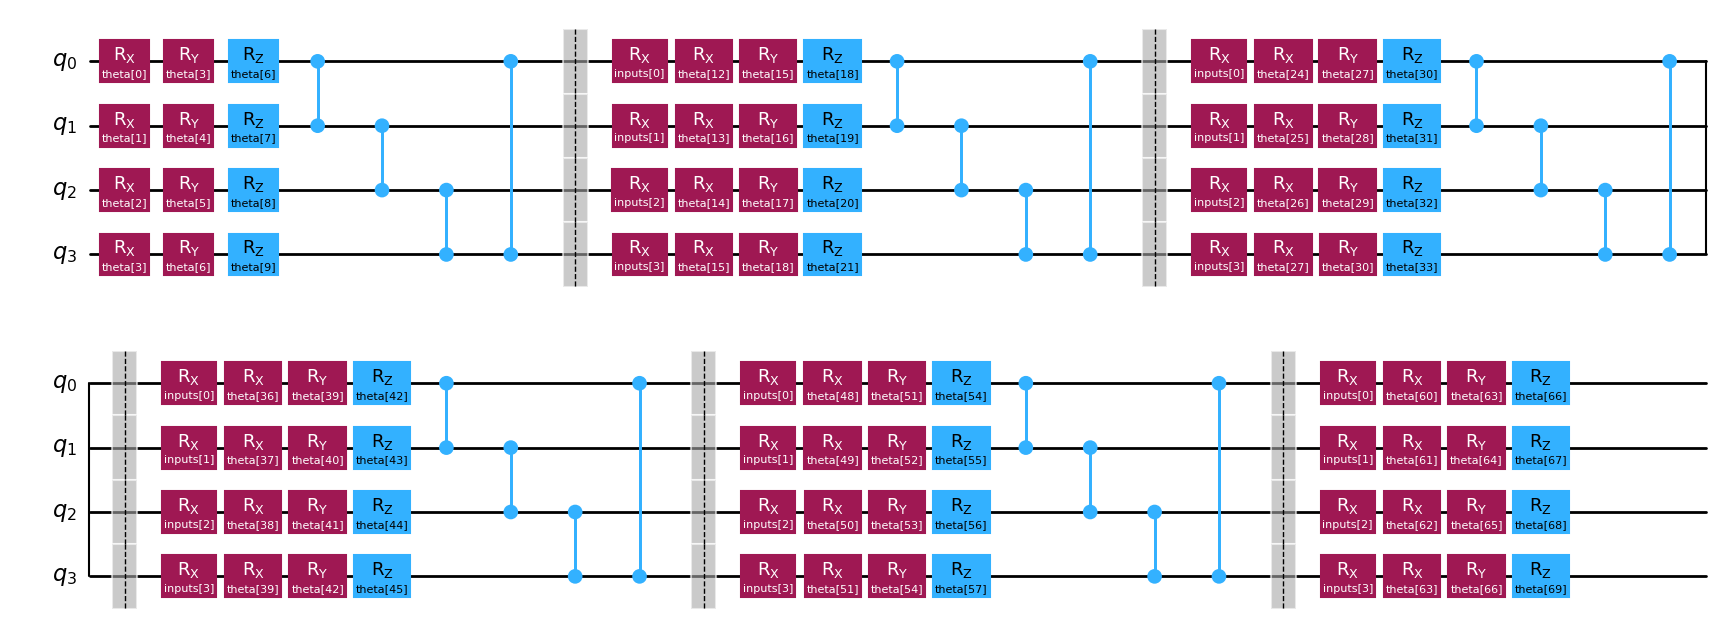

In [7]:
qc = QuantumCircuit(4)
qc, params, inputs = generate_circuit(qc, 5)
qc.draw("mpl", style="iqx")

In [8]:
qc.num_parameters

64

In [9]:
initial_weights = (2*np.random.rand(64) - 1)
initial_weights

array([ 0.51613904, -0.92907558,  0.48869018,  0.67691926, -0.41933748,
        0.64698039, -0.79076326,  0.04634893,  0.46860563, -0.51699791,
        0.85864654,  0.50169277,  0.86537216, -0.61113114, -0.82923998,
        0.77746954, -0.26637763,  0.73356111,  0.45078735, -0.78008106,
        0.9090672 , -0.73973971, -0.45507918, -0.42865457,  0.86856762,
        0.56181149,  0.59623684,  0.57378421,  0.74009207, -0.45213053,
        0.98949202,  0.73950098,  0.30575953, -0.96482378,  0.98207432,
       -0.44014316,  0.78808359, -0.11300687, -0.21702618, -0.31348283,
       -0.04166765, -0.17583675, -0.38273659, -0.39914838,  0.0824414 ,
        0.64763611,  0.81050471,  0.0173998 ,  0.38577531,  0.61759027,
       -0.80725041, -0.27108255,  0.5754728 , -0.50799977, -0.08238565,
       -0.13515809,  0.22267997, -0.24987881, -0.90366407, -0.2968648 ,
        0.63531045,  0.40122671,  0.92248874, -0.21283896])

In [10]:
def interpret(params):
    n_qubits = 3
    n_layers = 1
    n_params = 3*n_qubits*n_layers+3*n_qubits
    return np.array(params[:n_params]), np.array(params[n_params:])

In [11]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn=SamplerQNN(circuit=qc, input_params=inputs, weight_params=params, output_shape=2)

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


In [13]:
from qiskit_machine_learning.connectors import TorchConnector
qnn=TorchConnector(sampler_qnn)
qnn

MissingOptionalLibraryError: "The 'PyTorch' library is required to use 'TorchConnector'. You can install it with 'pip install 'qiskit-machine-learning[torch]''."

In [14]:
import torch

ImportError: libcudnn.so.8: cannot open shared object file: No such file or directory